In [1]:
import serial
import time as t
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 7.1

### arduino code for 7.1
```c 
int value;
int analog = A2;
int digital = 3;
int arr[26];
int arri=0;

void setup() {
TCCR1B = TCCR1B & 0b11111000 | 0x01 ;

pinMode(digital, OUTPUT);
pinMode(analog, INPUT);
Serial.begin(9600);
}

void loop()
{
  for(value=0; value<256; value=value+10){
    analogWrite(digital, value);
    delay(5000);
 
    arr[arri] = analogRead(analog);
    Serial.print(",");
    Serial.println(arr[arri]);
    arri++;
  }

  //Write array values to serial port. Note that we round our 10-bit measurements to 8-bit.
  for(int readingPtr = 0; readingPtr < 26; readingPtr++){
    Serial.write(arr[readingPtr]); //shift bits left six times and use only top eight }
  }
    arri=0;

 }

```

In [ ]:

# load datas

COM5_out_a1 = [0,38,78,118,158,199,239,279,320,359,400,440,480,520,560,601,641,681,721,762,802,841,882,922,962,1002]

COM5_out_a2 = [0,38,78,118,158,199,239,279,319,359,399,440,480,520,560,601,641,681,721,762,802,842,882,922,962,1001]


V_output_a1 = [0.003, 0.201, 0.400, 0.598, 0.797, 0.995, 1.194, 1.392, 1.591, 1.790,  1.988, 2.187, 2.385, 2.584, 2.783, 2.981, 3.180, 3.37, 3.57, 3.77, 3.97, 4.17, 4.37, 4.57, 4.76, 4.96, 5.06] 

V_output_a2 = [0.004, 0.201, 0.399, 0.598, 0.796, 0.994, 1.192, 1.391, 1.589, 1.787, 1.985, 2.184, 2.382, 2.580, 2.778, 2.976, 3.175, 3.37, 3.57, 3.76,
3.96, 4.16, 4.36, 4.56, 4.76, 4.95, 5.05] 

#wierd behaviour caused by multimeter not precise enough, as the values do not have an error bar
#a more accurate version of the plot can be established by including error bar from the multimeter


parameters and their errors are  [0.00476658 0.01979524] [8.74051114e-04 5.77951570e-06]


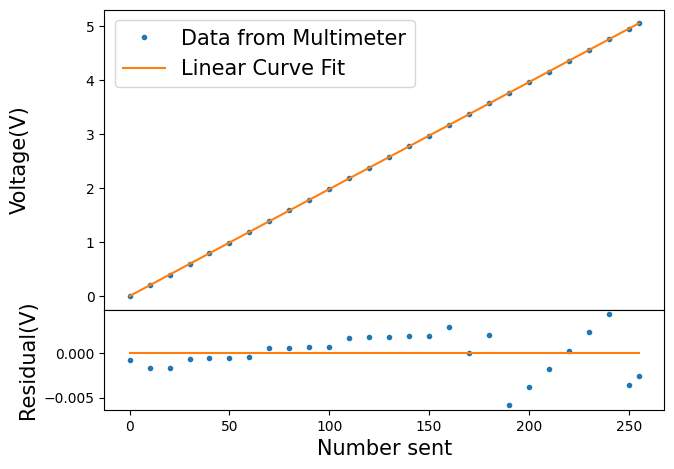

In [160]:
# try curve fit
def model(x,a,b):
    return a+b*x

V_output=V_output_a2
V_input = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 255]
a, acov = curve_fit(model, V_input, V_output)
aerr = np.sqrt(np.diag(acov))
print('parameters and their errors are ',a,aerr)

x = list(range(256))
y = [model(i, a[0], a[1]) for i in x]

g = plt.figure(figsize=(7,5))

upperframe = g.add_axes((.1,.3,.8,.6))
plt.plot(V_input, V_output,'.', label='Data from Multimeter')
plt.plot(x, y, label='Linear Curve Fit')
plt.ylabel('Voltage(V)', fontsize=15,labelpad=40)
plt.legend(fontsize=15)
upperframe.set_xticklabels([])

lowerframe = g.add_axes((.1,.1,.8,.2)) 
fx = [model(i, a[0], a[1]) for i in V_input]
res = [i-j for i,j in zip(V_output, fx)]
plt.plot(V_input, res, '.')
plt.plot(V_input, np.zeros(len(V_input))  )
plt.xlabel('Number sent', fontsize=15)
plt.ylabel('Residual(V)', fontsize=15)
plt.savefig("7_1.pdf", bbox_inches='tight')
plt.show()

[-1.88888889  4.01664957] [-1.99145299  4.0168547 ]


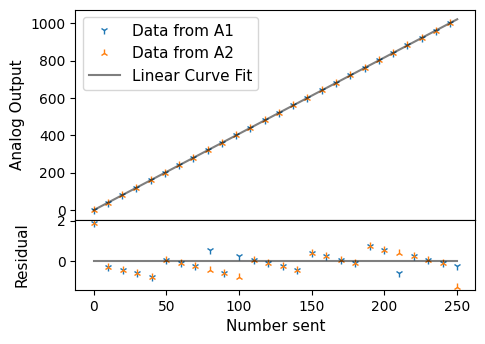

In [161]:
# try curve fit
def model(x,a,b):
    return a+b*x

V_input = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]

a, acov = curve_fit(model, V_input, COM5_out_a1)
a2, acov = curve_fit(model, V_input, COM5_out_a2)
print(a,a2)

x = list(range(256))
y = [model(i, a[0], a[1]) for i in x]
#y2 = [model(i, a2[0], a2[1]) for i in x]
g = plt.figure(figsize=(5,3.5))

upperframe = g.add_axes((.1,.3,.8,.6))
plt.plot(V_input, COM5_out_a1,'1', label='Data from A1')
plt.plot(V_input, COM5_out_a2,'2', label='Data from A2')
plt.plot(x, y, label='Linear Curve Fit',color='k', alpha=0.5)
plt.ylabel('Analog Output', fontsize=11)#,labelpad=40)
plt.legend(fontsize=11)
upperframe.set_xticklabels([])

lowerframe = g.add_axes((.1,.1,.8,.2)) 
fx = [model(i, a[0], a[1]) for i in V_input]
plt.plot(V_input, [i-j for i,j in zip(COM5_out_a1, fx)], '1')
plt.plot(V_input, [i-j for i,j in zip(COM5_out_a2, fx)], '2')
plt.plot(V_input, np.zeros(len(V_input)) ,color='k', alpha=0.5)
plt.xlabel('Number sent', fontsize=11)
plt.ylabel('Residual', fontsize=11,labelpad=20)
plt.savefig("7_1_2.pdf", bbox_inches='tight')
plt.show()

### arduino code for 7.2 and 7.3
```c 
int outputPin = 10;
int input = A1;
int arraysize = 800;
int readings[800]; //The array that will hold our readings
int timeBase=10; //Time between analog readings (for stability)
int readingPtr; //The array pointer that points to the current reading

void setup()
{
//TCCR2B = TCCR2B & 0b11111000 | 0x01 ;
//TCCR1B = TCCR1B & 0b11111000 | 0x04 ;
//pinMode(9, OUTPUT);
//pinMode(3, OUTPUT);
pinMode(10, OUTPUT);
pinMode(input, INPUT);
Serial.begin(9600);
}

void loop()
{
if(Serial.available() > 0)
  {
   analogWrite(outputPin, 0);
   delay(5000);
   analogWrite(outputPin, 255);
    
  for(readingPtr = 0; readingPtr < arraysize; readingPtr++){
    readings[readingPtr] = analogRead(input);
    delayMicroseconds(timeBase);
    }
    
  for(readingPtr = 0; readingPtr < arraysize; readingPtr++)
    {
    Serial.write(highByte(readings[readingPtr]<<6)); //shift bits left six times and use only top eight }
    }
  }
}
```

## 7.3

In [162]:
import pandas as pd

# load data from somewhere else
df = pd.DataFrame(data={'data1':dataOut[:250],'data2':dataOut2[:250],'data3':dataOut3[:250],'data4':dataOut4[:250],'data5':dataOut5[:250]})
df['avg'] = df.mean(axis=1)
df['std'] = df.std(axis=1)

df[:][:5]

,data1,data2,data3,data4,data5,avg,std
0,12,12.0,11.0,12.0,12.0,11.8,0.4
1,24,24.0,24.0,24.0,24.0,24.0,0.0
2,35,36.0,35.0,35.0,35.0,35.2,0.4
3,46,46.0,46.0,46.0,46.0,46.0,0.0
4,56,57.0,56.0,56.0,56.0,56.2,0.4


[252.9011513  215.00546255  14.77644732] [0.08262532 0.64549408 0.43340649]


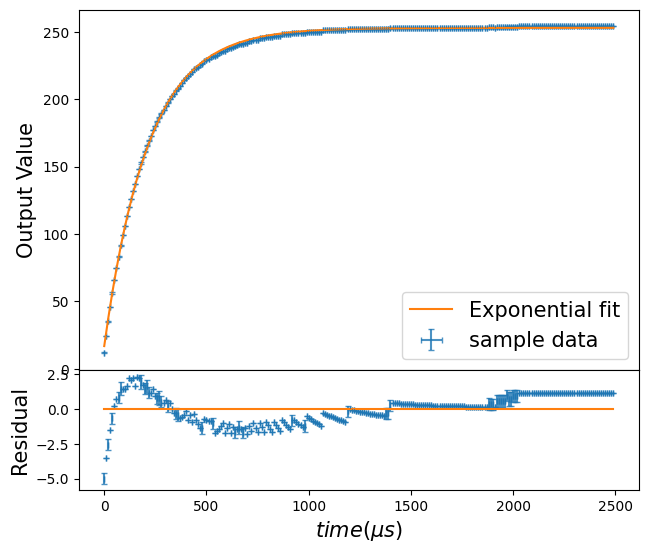

In [174]:

def expooo(t, V, tau, c0):
    return V*(1-np.exp(-(t+c0)/tau))

arraySize = len(df)
timearray = list(range(0,10*arraySize,10))

a, acov = curve_fit(expooo, timearray , df['avg'], p0=[254,218,0])
aerr = np.sqrt(np.diag(acov))
print(a,aerr)

y = [expooo(i, a[0],a[1],a[2]) for i in timearray]

f = plt.figure(figsize=(7,6))
#plt.plot(timearray, dataOut[:250],'.', marker="1", alpha=0.5, label='Output from Adruino')

upperframe = f.add_axes((.1,.3,.8,.6))
plt.errorbar(timearray, df['avg'], df['std'], np.zeros(arraySize), ',', capsize=2, label="sample data", alpha=0.8)
plt.plot(timearray, y, "-", label='Exponential fit')
plt.legend(fontsize=15)
plt.ylabel('Output Value', fontsize=15)

upperframe.set_xticklabels([])

lowerframe = f.add_axes((.1,.1,.8,.2)) 
res = [i-j for i,j in zip(df['avg'], y)]
plt.errorbar(timearray,res, df['std'], np.zeros(arraySize), ',', capsize=2, label="sample data", alpha=0.8)
plt.plot(timearray, np.zeros(arraySize))
plt.xlabel('$time (\mu s)$', fontsize=15)
plt.ylabel('Residual', fontsize=15)
plt.savefig("7_3.pdf", bbox_inches='tight')
plt.show()



## 7.4

### arduino code for 7.4
```c 
# define BLUE 3
# define GREEN 5
# define RED 6

void setup()
{
  pinMode(RED, OUTPUT);
  pinMode(GREEN, OUTPUT);
  pinMode(BLUE, OUTPUT);
  digitalWrite(RED, HIGH);
  digitalWrite(GREEN, LOW);
  digitalWrite(BLUE, LOW);
  Serial.begin(9600);
}
 
int redValue;
int greenValue;
int blueValue;
 
void loop()
{
  if(Serial.available() > 0){
  int out=Serial.read();
  analogWrite(RED, out*1.9);
  analogWrite(GREEN, out*0.95);
  analogWrite(BLUE, out/55);
  delay(10);
  }
}
```

In [2]:
# copy from lab1

# uniform distribution
def uniform_pdf(x):
    return np.linspace(1,1,len(x))
def uniform_cdf(x):
    return np.array(x)
def uniform_reverse(nsamp):
    rs = np.random.rand(nsamp)
    return np.array(rs)

# linear distribution
def linear_pdf(x):
    x = np.array(x)
    # cuz integral of y=ax yield 1 when a=2
    return x*2
def linear_cdf(x):
    x = np.array(x)
    return x**2
def linear_reverse(nsamp):
    rs = np.random.rand(nsamp)
    return [np.sqrt(i) for i in rs]

# exponential distribution
def exp_pdf(x, a = 1):
    x = np.array(x)
    return a*np.exp(-a * x)
def exp_cdf(x, a = 1):
    x = np.array(x)
    return 1 - np.exp(-a * x)
def exp_reverse(nsamp,  a=1):
    rs = np.random.rand(nsamp)
    return [-(1/a) * np.log(1 - i) for i in rs]
    
# gaussian distribution
def gaussian_pdf(x, mu = 0, sigma = 1):
    x = np.array(x)
    return [1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(i-mu)**2 / (2 * sigma**2)) for i in x] 
    
def gaussian_cdf(x, mu = 0, sigma = 1):
    arr = gaussian_pdf(x, mu, sigma)
    return [i/np.sum(arr) for i in np.cumsum(arr)]

# use uniform generstor to generate theta; exp genertor to generator mu
def gaussian_generator(nsamp):
    thetas = [i*2*np.pi for i in uniform_reverse(nsamp)]
    mus = [i for i in exp_reverse(nsamp)]    # r**2<2 cancelled with 2 below ; sigma**2 in mu cancel with that in r
    x = [np.cos(i)*np.sqrt(2 * j) for i,j in zip(thetas, mus)]
    y = [np.sin(i)*np.sqrt(2 * j) for i,j in zip(thetas, mus)]
    # one can check y use above arr
    return x

In [3]:
nsamp=200

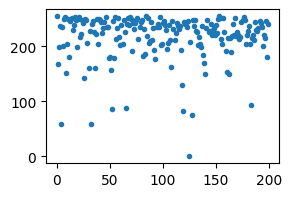

In [5]:
exp_sample = exp_reverse(nsamp)
max = np.max(exp_sample)
exp_sample = [(max-i)*255/max for i in exp_sample]
plt.figure(figsize=(3,2))
plt.plot(range(nsamp), exp_sample,'.')

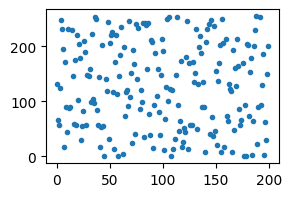

In [6]:
uni_sample = uniform_reverse(nsamp)
uni_sample = [i*255 for i in uni_sample]
plt.figure(figsize=(3,2))
plt.plot(range(nsamp), uni_sample,'.')

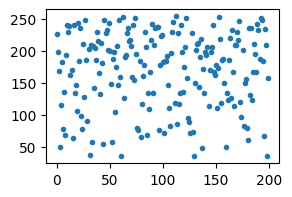

In [7]:
lin_sample = linear_reverse(nsamp)
lin_sample = [i*255 for i in lin_sample]
plt.figure(figsize=(3,2))
plt.plot(range(nsamp), lin_sample,'.')

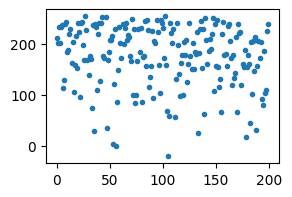

In [8]:
gau_sample = gaussian_generator(nsamp)
max = np.max(gau_sample)
gau_sample = [(max-np.abs(i))*255/max for i in gau_sample]
plt.figure(figsize=(3,2))
plt.plot(range(nsamp), gau_sample,'.')